# GGOR solution, steady state

@TO 2020-10-31

In this notbook we directly use the funtion defined in the modules `ggor_analytical.py` and `gg_modflow.py` with data specified within this notebook.

We will verify the steady state solutions/outcomes of

1. The single layer solution without regional underlying aquifer.
2. The single layer solution with regional underlying aquifer with given head.
3. The singel layer solution with regional underlying aquifer with given seepage.
4. The two-layer solution with given reginal seepage.
5. The numeric MODFLOW solution with given regional seepage.


The single layer solution without underlying regional aquifer is

$$h - h_{LR} =  \frac{N\left(b^2 - x^2\right)}{2 kD} + N b \frac{w}{D}$$

and the one with underlying aquifer is

$$h-\phi = Nc - \frac{b}{\lambda}\left(Nc - \left(h_{LR}-\phi\right)\right)\Lambda
\left(\frac{\cosh\frac x \lambda}{\sinh\frac b \lambda}\right)$$
with
$$\Lambda=\frac{1}{\frac{b}{\lambda}\mbox{ctanh}\frac{b}{\lambda}+\frac{b/c}{D/w}}$$

The expressions for the analytical multi-layer solutions are given in the theory. And, of course, the numerical solution can't be captured in a single expression.

In [130]:
# Modules
import numpy as np
import pandas as pd
import scipy.linalg as la
import matplotlib.pyplot as plt
import matplotlib
import flopy.utils.binaryfile as bf
import pdb
import os

PYTHON = os.path.expanduser('~/GRWMODELS/python/')
TOOLS  = os.path.expanduser('~/GRWMODELS/python/tools')
HOME = os.path.join(PYTHON, 'GGOR')

import sys
sys.path.insert(0, TOOLS)
sys.path.insert(0, PYTHON)

import GGOR.src.numeric.gg_mflow as gn
import GGOR.src.analytic.ggor_analytical as ga

from importlib import reload

matplotlib.rc('font', size=10)

ayear = 365 # days

### Dirs is a Dir_struct object which holds the GGOR directory structure, so that cases are stored properly.

In [5]:
dirs = gn.Dir_struct(home=HOME, case='Steady_basic')

# cd to workign directory, with the case_name
dirs.cwd()

print("Actual current directory:\n", os.path.abspath(os.curdir))

Actual current directory:
 /Users/Theo/GRWMODELS/python/GGOR/cases/Steady_basic


## Define parcel/section properties

These are the properties that may be required by any of the variants of the GGOR models.

Normally, these properties are stored in a pd.DataFrame, with each record holding all the static properties of a single parcel. For this steady-state verification, it suffices, however, to make a single record pandas DataFrame for the parcel properties and a single record pandas DataFrame for the time data.

In [514]:
# Properties

# Put them in a pandas DataFrame and show them
columns = ['AHN', 'b', 'd_drain', 'c_drain',
           'ET_surfd', 'ET_exdp',
           'sy', 'S2', 'kh', 'kv', 'D1', 'D_CB', 'c_CB', 'kh2', 'kv2', 'D2',
           'wo_ditch', 'wi_ditch', 'wo_ditch2', 'wi_ditch2',
           'co_ditch', 'ci_ditch', 'ditch_omega1', 'ditch_omega2', 'wpp1', 'wpp2',
           'd_trench', 'n_trench',
           'q_up', 'phi', 'h_summer', 'h_winter']
pdata = [[0.8, 75., 0.5, 10000.,
          1.0, 1.5,
          0.15, 0.001, 10., 5000., 15., 0.1, 15., 30., 15000., 25.,
          0.001, 0.002, np.inf, np.inf,
          0.001, 0.002, 1.25, 0., 0.1, 0.1,
          0.3, 0,
          0.00,  -.55, -0.3, -0.3]]
pdata = pd.DataFrame(pdata, columns=columns)
pdata['h_drain'] = pdata['AHN'] - pdata['d_drain']

props = pdata.iloc[0]

pdata

,AHN,b,d_drain,c_drain,ET_surfd,ET_exdp,sy,S2,kh,kv,...,ditch_omega2,wpp1,wpp2,d_trench,n_trench,q_up,phi,h_summer,h_winter,h_drain
0,0.8,75.0,0.5,10000.0,1.0,1.5,0.15,0.001,10.0,5000.0,...,0.0,0.1,0.1,0.3,0,0.0,-0.55,-0.3,-0.3,0.3


In [414]:
tdata = pd.DataFrame({'RH':0.005, 'EV24':0.00}, index=[pd.Timestamp('2020-10-31')])
tdata['summer'] = [t.month >= 4 and t.month <=9 for t in tdata.index]
tdata

,RH,EV24,summer
2020-10-31,0.005,0.0,False


# Single-layer steady-state solution

1. Single layer without a regional aquifer (Solution name = 'L1')
2. Top aquifer with given head in the regional aquifer (Solution name = 'L1f')
3. Top aquifer with given seepage in the regional aquifer (Solution name = 'L1q'

In [515]:
reload(ga)
hs, x, success = ga.single_layer_steady(solution_name='L1',
                       props=props, tdata=tdata, dx=1.0, verbose=False)
hq, x, success = ga.single_layer_steady(solution_name='L1q',
                       props=props, tdata=tdata, dx=1.0, verbose=False)
props.loc['phi'] = hq[1].mean()
hf, x, success = ga.single_layer_steady(solution_name='L1f',
                       props=props, tdata=tdata, dx=1.0, verbose=False)


/Users/Theo/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/Users/Theo/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


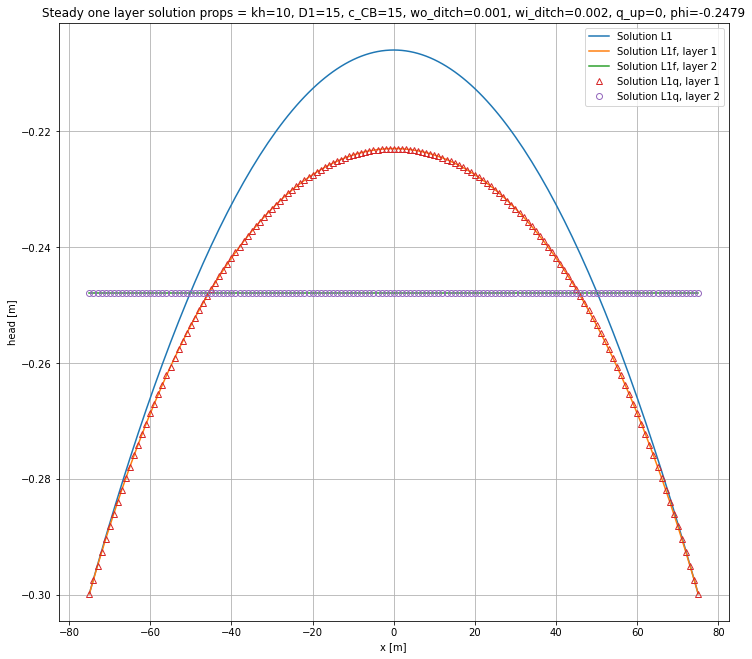

In [516]:
# Title header with all used properties in it
vnm = 'kh D1 c_CB wo_ditch wi_ditch q_up phi'
txt = ', '.join([k +'={:.4g}'.format(props[k]) for k in vnm.split(' ')])

ax = ga.newfig("Steady one layer solution props = {}".format(txt), "x [m]", "head [m]")

ax.plot(x, hs, label="Solution {}".format('L1'))
ax.plot(x, hf[0], label="Solution {}, layer 1".format('L1f'))
ax.plot(x, hf[1], label="Solution {}, layer 2".format('L1f'))
ax.plot(x, hq[0], '^', mfc='none', label="Solution {}, layer 1".format('L1q'))
ax.plot(x, hq[1], 'o', mfc='none', label="Solution {}, layer 2".format('L1q'))
ax.legend()

# Multi-layer (2-layer) steady

In [517]:
reload(ga) # make sure when the module ga is edited, that it's reloaded

<module 'GGOR.src.analytic.ggor_analytical' from '/Users/Theo/GRWMODELS/python/GGOR/src/analytic/ggor_analytical.py'>

In [518]:
# Compute the head 
phi, x = ga.multi_layer_steady(props=props, tdata=tdata, dx=1., plot=False)

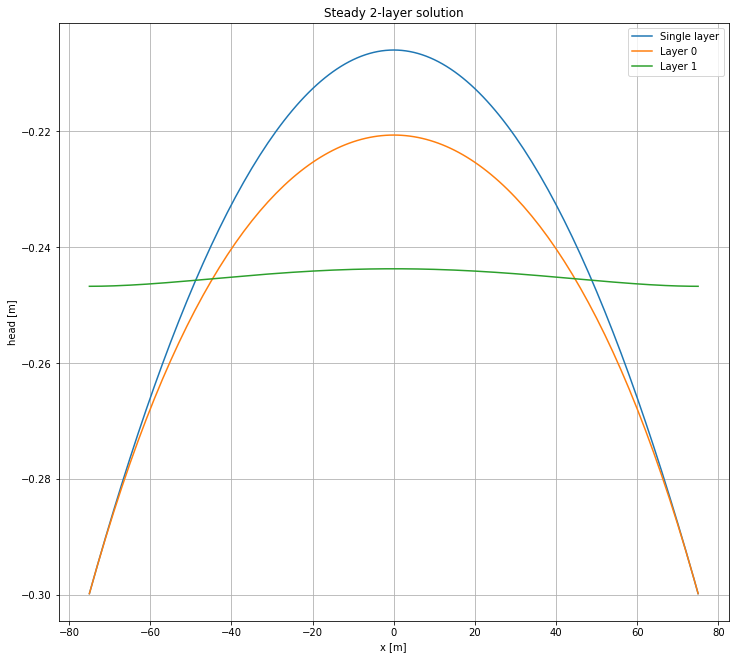

In [519]:
# Show it
ax = ga.newfig("Steady 2-layer solution", "x [m]", "head [m]")

ax.plot(x, hs, label='Single layer')
ax.plot(x, phi[0], label="Layer 0")
ax.plot(x, phi[1], label="Layer 1")
ax.legend()

# Numerical solution using MODFLOW

Modflow uses the same pd.DataFrames as the analytical solution. It does use more some extra parameters like `kv` and `kv1` and the thickness of the confining bed, `D_CB`, which is obvious. For comparison it should be watched that `kv` and `kv1` are high, so that the vertical conductivity of the aquifer layers do not cause substantial extra vertical resistance in the system that is not included in the analytical solutions.

In [520]:
reload(gn) # Make sure the numeric module is reloaded after editing.

par, spd, bdd, gr = gn.run_modflow(dirs=dirs, parcel_data=pdata, tdata=tdata,
        laycbd=(1, 0), dx=0.1, use_w_not_c=True)

adding Package:  DIS
adding Package:  BAS6
Adding Steady_basic.cbc (unit=53) to the output list.
adding Package:  LPF
adding Package:  GHB
adding Package:  RIV
adding Package:  DRN
adding Package:  WEL
adding Package:  RCH
adding Package:  EVT
Adding Steady_basic.hds (unit=51) to the output list.
adding Package:  OC
adding Package:  SMS
Pakages used:[dis, bas, lpf, ghb, riv, drn, wel, rch, evt, oc, sms]

Writing packages:
   Package:  DIS
   Package:  BAS6
   Package:  LPF
   Package:  GHB
   Package:  RIV
   Package:  DRN
   Package:  WEL
   Package:  RCH
   Package:  EVT
   Package:  OC
   Package:  SMS
 
FloPy is using the following  executable to run the model: /Users/Theo/GRWMODELS/python/GGOR/bin/mfusg.mac

                                  MODFLOW-USG      
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUNDWATER FLOW MODEL
                             Version 1.4.00 10/27/2017                       

 Using NAME file: Steady_basic.nam 
 Run start date and time (yyyy/mm/

In [521]:
case_name = os.path.basename(dirs.case)
hds_file = os.path.join(dirs.case_results, case_name +'.hds')
print("\nReading binary head file '{}' ...".format(hds_file))
HDS = bf.HeadFile(hds_file)
hds = HDS.get_alldata()[-1]


Reading binary head file '/Users/Theo/GRWMODELS/python/GGOR/cases/Steady_basic/Steady_basic.hds' ...


# Comparison

In the picture below, all computed solutions are combined, so that they are easily compared.

A first direct comparison between all solution is done by setting `q_up=0` and makeing the vertical resistance of the confining bed large. The drainage resistance in the 2-layer model is also made large (both 15000 d) to make sure that only the top layer is active. In that case all solution should yield the same outcome, which they do.

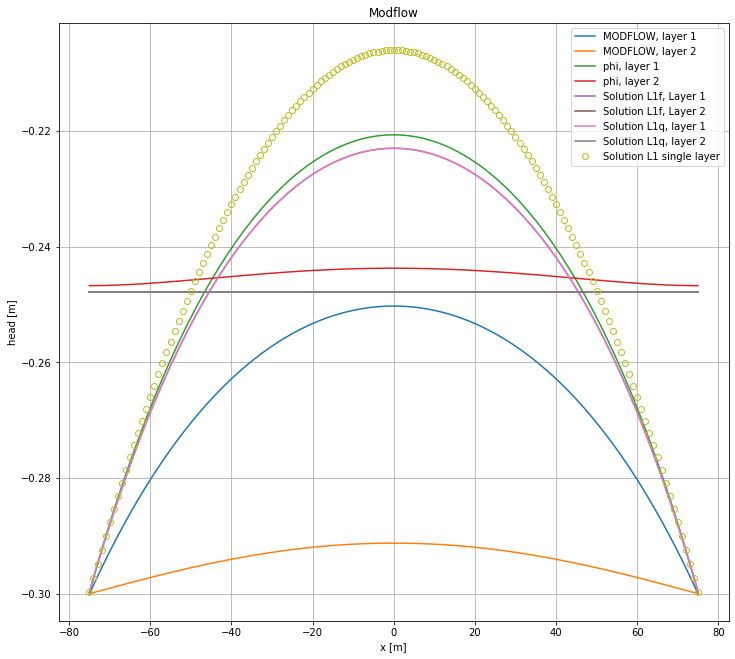

In [522]:
ax = ga.newfig("Modflow", "x [m]", "head [m]")
xm = np.hstack((gr.xm - props['b'], props['b'] - gr.xm[::-1]))
ax.plot(xm , np.hstack((hds[0, 0, :], hds[0, 0, :][::-1])), label="MODFLOW, layer 1")
ax.plot(xm , np.hstack((hds[1, 0, :], hds[1, 0, :][::-1])), label="MODFLOW, layer 2")

ax.plot(x, phi[0], label="phi, layer 1")
ax.plot(x, phi[1], label="phi, layer 2")

ax.plot(x, hf[0], label="Solution {}, Layer 1".format('L1f'))
ax.plot(x, hf[1], label="Solution {}, Layer 2".format('L1f'))

ax.plot(x, hq[0], label="Solution {}, layer 1".format('L1q'))
ax.plot(x, hq[1], label="Solution {}, layer 2".format('L1q'))
ax.plot(x, hs, 'o', mfc='none', label="Solution {}".format('L1 single layer'))
ax.legend()

### Show the effect of the ditch resistance $w$ on $\Lambda$

In [523]:
# Entry resistance
use_w_not_c = True
pdata['wo_ditch'] = 10.0
pdata['wi_ditch'] = 20.0
props = pdata.iloc[0]
props

AHN                 0.800
b                  75.000
d_drain             0.500
c_drain         10000.000
ET_surfd            1.000
ET_exdp             1.500
sy                  0.150
S2                  0.001
kh                 10.000
kv               5000.000
D1                 15.000
D_CB                0.100
c_CB               15.000
kh2                30.000
kv2             15000.000
D2                 25.000
wo_ditch           10.000
wi_ditch           20.000
wo_ditch2             inf
wi_ditch2             inf
co_ditch            0.001
ci_ditch            0.002
ditch_omega1        1.250
ditch_omega2        0.000
wpp1                0.100
wpp2                0.100
d_trench            0.300
n_trench            0.000
q_up                0.000
phi                -0.550
h_summer           -0.300
h_winter           -0.300
h_drain             0.300
Name: 0, dtype: float64

In [525]:
reload(ga)
hs, x, success = ga.single_layer_steady(solution_name='L1',
                       props=props, tdata=tdata, dx=1.0, verbose=False,
                                        use_w_not_c=use_w_not_c)
hq, x, success = ga.single_layer_steady(solution_name='L1q',
                       props=props, tdata=tdata, dx=1.0, verbose=True,
                                       use_w_not_c=use_w_not_c)

# Adapt phi, but use two-step approach to prevent pd warning
pdata['phi'] = hq[1].mean()
props = pdata.iloc[0]

hf, x, success = ga.single_layer_steady(solution_name='L1f',
                       props=props, tdata=tdata, dx=1.0, verbose=False,
                                       use_w_not_c=use_w_not_c)

# Compute the head  and then read the heads
phi, x = ga.multi_layer_steady(props=props, tdata=tdata, dx=1., plot=False,
                               use_w_not_c=use_w_not_c)

reload(gn)
par, spd, bdd, gr = gn.run_modflow(dirs=dirs, parcel_data=pdata, tdata=tdata,
        laycbd=(1, 0), dx=1.0, use_w_not_c=use_w_not_c)

case_name = os.path.basename(dirs.case)
hds_file = os.path.join(dirs.case_results, case_name +'.hds')
print("\nReading binary head file '{}' ...".format(hds_file))
HDS = bf.HeadFile(hds_file)
hds = HDS.get_alldata()[-1]

iter=0, np.max(np.abs(hx - hk_prev)) = 0.06892524807071615
iter=1, np.max(np.abs(hx - hk_prev)) = 0.05313538966123588
iter=2, np.max(np.abs(hx - hk_prev)) = 0.040652570640398844
iter=3, np.max(np.abs(hx - hk_prev)) = 0.03257062196392718
iter=4, np.max(np.abs(hx - hk_prev)) = 0.026095407950975535
iter=5, np.max(np.abs(hx - hk_prev)) = 0.020907501148796824
iter=6, np.max(np.abs(hx - hk_prev)) = 0.016750977992302303
iter=7, np.max(np.abs(hx - hk_prev)) = 0.013420793891227092
iter=8, np.max(np.abs(hx - hk_prev)) = 0.010752668217555383
iter=9, np.max(np.abs(hx - hk_prev)) = 0.008614980211595673
iter=10, np.max(np.abs(hx - hk_prev)) = 0.006902276025313701
iter=11, np.max(np.abs(hx - hk_prev)) = 0.005530066600210569
iter=12, np.max(np.abs(hx - hk_prev)) = 0.004430659754928387
iter=13, np.max(np.abs(hx - hk_prev)) = 0.0035498208761526734
iter=14, np.max(np.abs(hx - hk_prev)) = 0.002844097482040342
iter=15, np.max(np.abs(hx - hk_prev)) = 0.0022786756767611896
iter=16, np.max(np.abs(hx - hk_prev

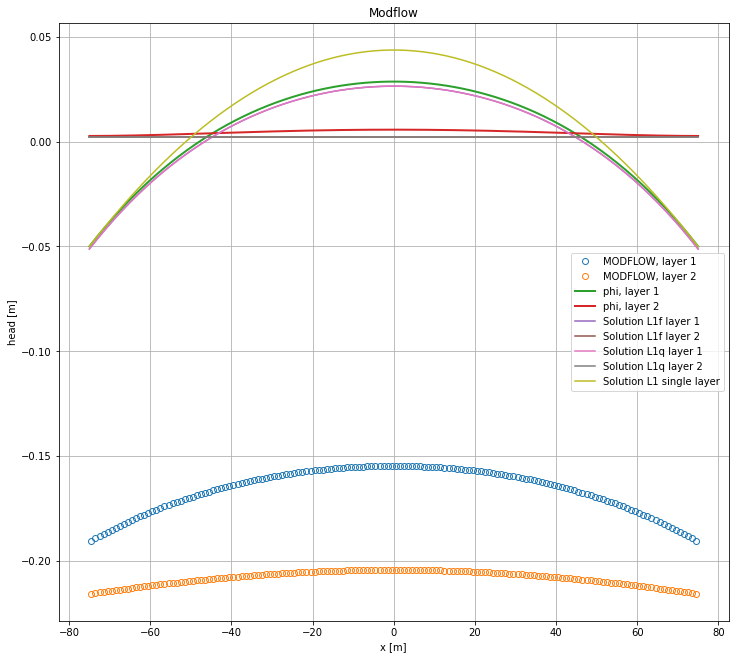

In [526]:
ax = ga.newfig("Modflow", "x [m]", "head [m]")
xm = np.hstack((gr.xm - props['b'], props['b'] - gr.xm[::-1]))

ax.plot(xm , np.hstack((hds[0, 0, :], hds[0, 0, :][::-1])), 'o', lw=0.5, mfc='none', label="MODFLOW, layer 1")
ax.plot(xm , np.hstack((hds[1, 0, :], hds[1, 0, :][::-1])), 'o', lw=0.5, mfc='none', label="MODFLOW, layer 2")

ax.plot(x, phi[0], lw=2., label="phi, layer 1")
ax.plot(x, phi[1], lw=2., label="phi, layer 2")

ax.plot(x, hf[0], label="Solution {} layer 1".format('L1f'))
ax.plot(x, hf[1], label="Solution {} layer 2".format('L1f'))

ax.plot(x, hq[0], label="Solution {} layer 1".format('L1q'))
ax.plot(x, hq[1], label="Solution {} layer 2".format('L1q'))
ax.plot(x, hs, label="Solution {}".format('L1 single layer'))
ax.legend()

In [491]:
phi

array([[-0.19023602, -0.18914947, -0.18808486, -0.18704183, -0.18602006,
        -0.1850192 , -0.18403892, -0.18307892, -0.18213889, -0.18121852,
        -0.18031751, -0.17943559, -0.17857247, -0.17772788, -0.17690156,
        -0.17609324, -0.17530268, -0.17452963, -0.17377385, -0.17303511,
        -0.17231318, -0.17160784, -0.17091888, -0.17024608, -0.16958925,
        -0.16894819, -0.1683227 , -0.1677126 , -0.16711771, -0.16653784,
        -0.16597284, -0.16542252, -0.16488674, -0.16436533, -0.16385814,
        -0.16336502, -0.16288583, -0.16242044, -0.1619687 , -0.1615305 ,
        -0.16110569, -0.16069417, -0.16029581, -0.1599105 , -0.15953814,
        -0.15917861, -0.15883182, -0.15849766, -0.15817605, -0.15786689,
        -0.1575701 , -0.1572856 , -0.1570133 , -0.15675313, -0.15650503,
        -0.15626891, -0.15604471, -0.15583238, -0.15563185, -0.15544308,
        -0.155266  , -0.15510057, -0.15494674, -0.15480448, -0.15467374,
        -0.15455448, -0.15444668, -0.15435031, -0.1

In [490]:
hds[:, 0, :]

array([[-0.19069503, -0.19058594, -0.19047709, ..., -0.15468383,
        -0.1546836 , -0.1546835 ],
       [-0.21578299, -0.21575494, -0.21572691, ..., -0.20431036,
        -0.20431027, -0.20431022]], dtype=float32)

In [381]:
pdata[['wi_ditch', 'wo_ditch']]
pdata['wo_ditch'] / pdata['D1'] * 0.005 * 75
(0.005 * 75) / (7.5 + 7.5)

0.025

For any value of the ditch resistance, $\frac{b}{\lambda}\Lambda$ will vary between 0 and 1 with $\frac{b}{\lambda}$. $\frac{b}{\lambda} \downarrow 0$ implies that the parcel width will become negligible compared to the aquifer system's spreading length $\lambda$. In that case the contact with the underlying aquifer gets lost and only the ditch water level matters as boundary condition.

The experssion that remains then reduces to

$$h - \phi = Nc$$

which is, of course, correct.

With $\frac{b}{\lambda} \rightarrow \infty$, we see that $\frac{b}{\lambda}\Lambda \uparrow 1$. This is the case when the width of the parcel is much larger than the spreading lenght. In that case the ditches will no longer play any role in the solution. The remaining expression

$$h-\phi = Nc - \frac{b}{\lambda}\left(Nc - \left(h_{LR}-\phi\right)\right)\Lambda
\left(\frac{\cosh\frac x \lambda}{\sinh\frac b \lambda}\right)$$
with
$$\Lambda=\frac{1}{\frac{b}{\lambda}\mbox{ctanh}\frac{b}{\lambda}+\frac{b/c}{D/w}}$$

### Show the effect of $c$ on $\Lambda$ (i.e. $\Lambda$ as a function of $b/\lambda$)

### Show $h(x)$ voor various $c$ and compare with the analytical solution for the case without a regional aquifer

#### First derive the solution for the case without a regional aquifer
The partial differential equation for the same situation but without a regional aquifer, which is equivalent to $c\rightarrow\infty$ is

$$\frac{d^{2}h}{dx^{2}}=-\frac{N}{kD}$$

With $x=0$, $\frac {dh}{dx}=0, the first integration constant drops so that after integrating twise

$$h=-\frac{1}{2}\frac{N}{kD}x^{2}+C_{2}$$

Boundary condition at $x-b$ yields

$$-kD\left(\frac{dh}{dx}\right)_{x=b}=\frac{D}{w}\left(h_{b}-h_{LR}\right)$$

filling in gives

$$-kD\left(-\frac{N}{kD}b\right)=\frac{D}{w}\left(-\frac{1}{2}\frac{N}{kD}b^{2}+C_{2}-h_{LR}\right)$$

so that

$$C_{2}=\frac{Nb^{2}}{2kD}+\frac{Nb}{D}w+h_{LR}$$

and, finally

$$h-h_{LR}=\frac{N\left(b^{2}-x^{2}\right)}{2kD}+Nb\frac{w}{D}$$

We will numerically show that for $\lambda\rightarrow\infty$ this function is the same as

$$h-\phi=Nc-\frac{b}{\lambda}\frac{\left(Nc-\left(h_{LR}-\phi\right)\right)}{\frac{b}{\lambda}\frac{\cosh\frac{b}{\lambda}}{\sinh\frac{b}{\lambda}}+\frac{b/c}{D/w}}\left(\frac{\cosh\frac{x}{\lambda}}{\sinh\frac{b}{\lambda}}\right)$$

## Numerically demonstrate that the latter two expressions are equivalent voor $c\rightarrow\infty$

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


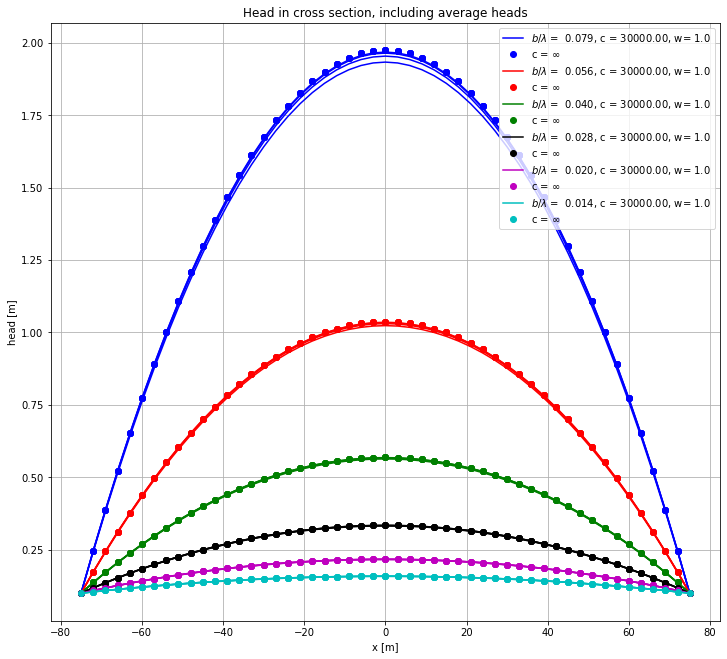

In [331]:
ax = ga.newfig('Head in cross section, including average heads', 'x [m]', 'head [m]')

clrs = ['b', 'r', 'g', 'k', 'm', 'c']
cvals = [5000, 10000, 20000, 30000]
# Show for ever larger c
for c in cvals:
    # For several data sets
    for ip, clr in zip(data0.index[:6], clrs):
        # Using data0 (not data)
        d = data0.iloc[ip]
        b, k, D,  w, hlr, phi, N = d[['b', 'k', 'D', 'w', 'hlr', 'phi', 'N']]
        x = np.linspace(-b, b, 51)
        lam = np.sqrt(k * D * c)
        blam = b  / lam
        Lam = 1 / (blam * np.cosh(blam) / np.sinh(blam) + (b / c) / (D / w))

        if c == cvals[-1]:
            label0 = '$b/\lambda$ = {:6.3f}, c = {:8.2f}, w={:4.1f}'.format(blam, c, w)
            label1 = 'c = $\infty$'
        else:
            label0=''
            label1 = ''
        h = phi + N * c - blam * (N * c - (hlr - phi)) * Lam * np.cosh(x / lam) / np.sinh(blam)
        ax.plot(x, h, color=clr, label=label0)

        # The analytical solution without aquitard and underlying regional aquifer
        h  = hlr + N * (b ** 2 - x ** 2) / (2 * k * D)  + N * b * w / D    
        ax.plot(x, h, 'x', lw=3, color=clr, marker='o', ls='none', label=label1)
    
    ax.legend()

### Show the graphs together with the cross-section averages

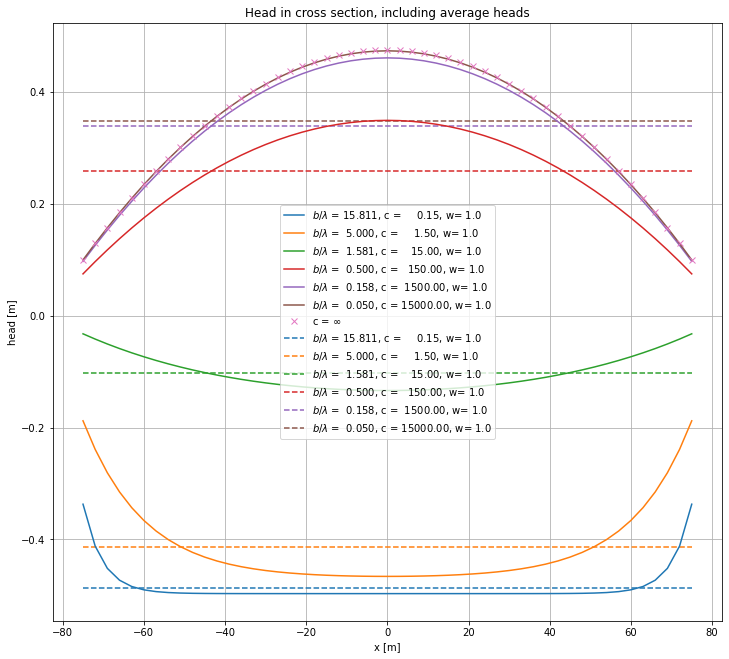

In [162]:
ax = ga.newfig('Head in cross section, including average heads', 'x [m]', 'head [m]')

for id in data.index[:6]:
    d = data.iloc[id]
    b, k, D, c, w = d['b'], d['k'], d['D'], d['c'], d['w']
    hlr, phi, N = d['hlr'], d['phi'], d['N']
    x = np.linspace(-b, b, 51)
    lam = np.sqrt(k * D * c)
    blam = b  / lam
    Lam = 1 / (blam * np.cosh(blam) / np.sinh(blam) + (b / c) / (D / w))
    
    h = phi + N * c - blam * (N * c - (hlr - phi)) * Lam * np.cosh(x / lam) / np.sinh(blam)
    label = '$b/\lambda$ = {:6.3f}, c = {:8.2f}, w={:4.1f}'.format(blam, c, w)
    hl = ax.plot(x, h, label=label)
    
    havg = phi + N * c - (N * c - (hlr - phi)) * Lam
    ax.hlines(havg, x[0], x[-1], ls='--', colors=hl[0].get_color(), label=label)
    
# The analytical solution without aquitard and underlying regional aquifer
h  = hlr + N * (b ** 2 - x ** 2) / (2 * k * D)  + N * b * w / D    
ax.plot(x, h, 'x', lw=3, label='c = $\infty$')
    
ax.legend()

The analytical solution for the situation without a regional aquifer indeed coincides with that for the case with a regional aquifer when $c\rightarrow\infty$.

The set of curves alsow show what happens when the resistance $c$ varies from very low to very high. If very low, the head in the shallow aquifer will become equal to the prescribed head in the regional aquifer except near the ditches on either side of the cross section. The greater the resistance, the smaller the influence of the deep aquifer, the more the solution will obey the recharge and the solution of the case without a regional aquifer.

### Show the effect o the wate table $h$ caused by the entry resistance $w$

The dashed lines are the cross-section averaged values.

The exact properties are given in the table above.

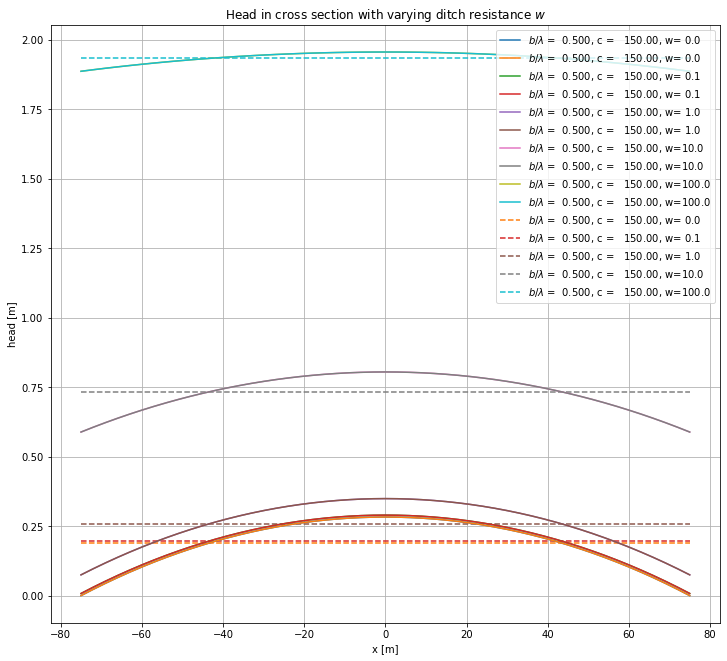

In [163]:
ax = ga.newfig('Head in cross section with varying ditch resistance $w$', 'x [m]', 'head [m]')

for id in data.index[6:]:
    d = data.iloc[id]
    b, k, D, c, w = d['b'], d['k'], d['D'], d['c'], d['w']
    hlr, phi, N = d['hlr'], d['phi'], d['N']
    x = np.linspace(-b, b, 51)
    lam = np.sqrt(k * D * c)
    blam = b / lam
    xlam = x / lam
    Lam = 1 / (blam * np.cosh(blam) / np.sinh(blam) + (b / c) / (D / w))
    
    h = phi + N * c - blam * (N * c - (hlr - phi)) * Lam * np.cosh(xlam) / np.sinh(blam)
    label = '$b/\lambda$ = {:6.3f}, c = {:8.2f}, w={:4.1f}'.format(blam, c, w)
    ax.plot(x, h, label=label)    
    
    hl = ax.plot(x, h, label=label)
    havg = phi + N * c - (N * c - (hlr - phi)) * Lam
    ax.hlines(havg, x[0], x[-1], ls='--', colors=hl[0].get_color(), label=label)

ax.legend()

Increasing the resistance between aquifer and ditch is like lifing the head parallelly. However there is still a small effect from the underlying regional aquifer, because a higher water table implies more downward leakage and less flow to the ditches.

# Transient simulation

Steady-state water balance says

$$0=N+\overline q - \overline q_b$$

When this is no longer true due to a change of one or more of the inputs, we attribute this deficit to storage

$$\mu \frac{d \overline h}{dt}=N+\overline q - \overline q_b$$

Filling in $\overline q_b$ yields

$$\mu \frac{d \overline h}{dt} = N - \frac{\overline h - \phi}{c} -
\left(N - \frac{h_{LR} - \phi}{c}\right)\Lambda$$

or

$$\mu c \frac{d \overline h}{dt} = -\left(\overline h -
\left[\phi + Nc\left(1 - \Lambda\right) + \left(h_{LR} - \phi\right) \Lambda\right]\right)
$$

or, with the so-called system characteristic time $T$

$$T = \mu c$$

we have

$$T\frac{d \overline h}{dt}=-\left(\overline h - \overline h_\infty\right)$$

with

$$\overline h_\infty = \phi + Nc\left(1 - \Lambda\right) + \left(h_{LR} - \phi\right) \Lambda$$

After integration and filling in the initial values, $\overline h = \overline h_0$ at $t=t_0$, this leads to the following dynamic relation that is valid as long as the boundaries are constant

$$\overline h - \phi = \left(\overline h_0 -\phi\right)e^{-\frac{t-t_0}{T}} +
\left[Nc\left(1 - \Lambda\right) + \left(h_{LR}-\phi\right)\Lambda\right]\left(1 - e^{-\frac{t-t_0}{T}}\right)$$

which represents the two processes that determine the groundwater head as course of time: 1) the decay towards the equilibrium without any recharge ($N=0$) and the striving towards the equilibrium $\overline h_\infty$ driven by both the recharge from precipication as that from inflow from the ditches. This basic dynamic equation alows us to simulate time series in a stepwise fashion, in which each step may be as long as the the boundaries can be assumed constant. Generally we'll simulate with daily steps, but this is not a requirement by any sense.

For the water budget components dust differentiate this equation with respect to time and multiply by the storage coefficient and noting that %T=\mu c$ plus a little rearangement so that we get the following three components of the water budget on the right-hand side that must balance the storaga: inflow from the regional aquifer, inflow recharge and outflow to the ditches:

$$\mu \frac{d\overline h}{dt} = \left[\frac{\phi - \overline h_0}{c} + N- \left(N  + \frac{\phi - h_{LR}}{c}\right)\Lambda\right] e^{-\frac{t-t_0}{T}}$$

For the true average over any time step with length $\Delta t$ we have to replace the exponent by $f$:

$$f = \left(1 - e^{-\frac{\Delta t}{T}}\right) / \frac{\Delta t}{T}$$

Hence, the average water budget components during any time step are as below, where the subscripts indicate the type of component in accordance with MODFLOW, that is, each component is positive as it add water to the considered layer. As can be seen the sum of these components is always zero. Their dimension is [L/T], i.e. average over the cross section, and their value is the exact average over the time step.

$$q_{STO} = -\mu\frac{\overline h_{t+\Delta t} - \overline h_t}{\Delta t}$$
$$q_{FLF} = \frac{\phi - h_0}{c} f$$
$$q_{RCH} = N$$
$$q_{GHB} = -\left(N  + \frac{\phi - h_{LR}}{c}\right)\Lambda f $$

In [203]:
prpcols = ['sy', 'b', 'k', 'D', 'c', 'w']

prpdata = [[0.25, 75., 10., 15.,  150.,  1.],
           [0.10, 75., 10., 15.,  150.,  1.],
           [0.05, 75., 10., 15.,  150.,  1.],
           [0.02, 75., 10., 15.,  150.,  1.],
        ]

prdcols = ['time', 'N', 'phi', 'hlr']

prddata = [['2020-01-01',  0.000, -0.5, 0.0],
           ['2020-03-01',  0.015, -0.5, 0.0],
           ['2020-06-01',  0.030, -0.5, 0.0],
           ['2020-09-01',  0.045, -0.5, 0.0],
           ['2020-12-01', -0.030, -0.5, 0.0],
           ['2021-02-01',  0.000, -0.5, 0.0],
        ]

In [204]:
propdata = pd.DataFrame(prpdata, columns=prpcols) # parcel properties
perdata  = pd.DataFrame(prddata, columns=prdcols) # stress periods

# Make index into pd.Timestamps (so use datetimes)
perdata.index = [pd.Timestamp(f) for f in perdata['time']]
perdata = perdata.drop(columns='time')

# Simulation time, real datetimes, dayly values
time = [tdata.index[0] + np.timedelta64(i, 'D') for i in range(720)]
tdata = pd.DataFrame(index=time, columns=['h', 'phi', 'hlr', 'N'])

# Dict to store water flow components à la MODDFLOW's budget file but dimension is [L/T]
# CBC['STO'][ip, it] will be the storage [m/d] of parcel ip at time it
CBC = dict()
for lbl in ['STO', 'FLF', 'RCH', 'GHB']:
    CBC[lbl] = np.zeros((len(propdata), len(tdata)))

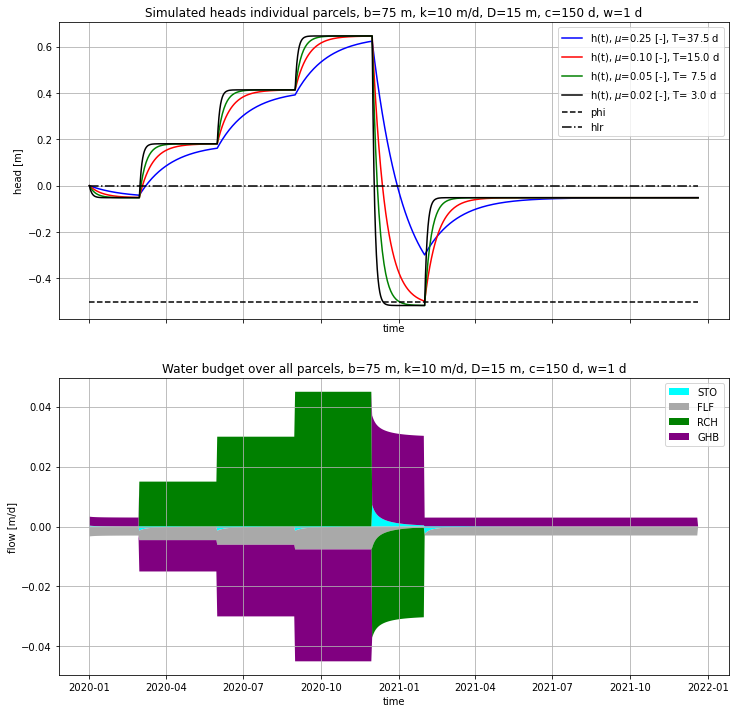

In [316]:
d = propdata.iloc[0]
ttl1 = 'Simulated heads individual parcels, b={:.0f} m, k={:.0f} m/d, D={:.0f} m, c={:.0f} d, w={:.0f} d'.format(
    d['b'], d['k'], d['D'], d['c'], d['w'])
ttl2 = 'Water budget over all parcels, b={:.0f} m, k={:.0f} m/d, D={:.0f} m, c={:.0f} d, w={:.0f} d'.format(
    d['b'], d['k'], d['D'], d['c'], d['w'])

ax = ga.newfig2([ttl1, ttl2], 'time', ['head [m]', 'flow [m/d]'], size_inches=(12,12))

clrs = ['b', 'r', 'g', 'k', 'm', 'c', 'purple', 'gray']

for ip in range(len(propdata)):
    d = propdata.iloc[ip]
    Sy, b, k, D, c, w = d['sy'], d['b'], d['k'], d['D'], d['c'], d['w']
    T = Sy * c
    lam = np.sqrt(k * D * c)
    blam = b / lam
    Lam = 1 / (blam * np.cosh(blam) / np.sinh(blam) + (b  / c) / (D  / w))

    dp = perdata.iloc[0]
    td = tdata.iloc[0]
    td[['h', 'phi', 'hlr', 'N']] = (0., dp['phi'], dp['hlr'], dp['N'])

    tprev = tdata.index[0]
    for it, t in enumerate(tdata.index[1:]):
        dt = (t - tprev) / np.timedelta64(1, 'D')
        h0 = tdata['h'].loc[tprev]
        perchange = perdata.index[perdata.index <= t][-1]
        prd  = perdata.loc[perchange]
        N, phi, hlr   = prd['N'], prd['phi'], prd['hlr']
        hinf = phi + N * c * (1 - Lam) + (hlr - phi) * Lam
        e = np.exp(-(dt) / T)
        f = (1 - e) * (T / dt)
        td = tdata.loc[t]
        h  = phi + (h0 - phi) * e + (hinf - phi) * (1 - e)
        ha = phi + (h0 - phi) * f + (hinf - phi) * (1 - f)
        td[['h','phi', 'hlr', 'N']] = h, phi, hlr, N
        
        CBC['STO'][ip, it] = -Sy * (h - h0) / dt
        CBC['FLF'][ip, it] = (phi - ha) / c
        CBC['RCH'][ip, it] = N
        #CBC['GHB'][ip, it] = -(N + (phi - hlr) / c) * Lam * f
        CBC['GHB'][ip, it] =  ((hlr - phi) / c - N) * Lam # zonder f, zie theorie
        
        tprev = t

    ax[0].plot(tdata.index, tdata['h'], color=clrs[ip % len(clrs)],
            label='h(t), $\mu$={:.2f} [-], T={:4.1f} d'.format(Sy, T))

ax[0].plot(tdata.index, tdata['phi'], 'k--', label='phi' )
ax[0].plot(tdata.index, tdata['hlr'], 'k-.', label='hlr')
ax[0].legend()

components = ['STO', 'FLF', 'RCH', 'GHB']
V = np.zeros((len(components), len(tdata)))
for ic, comp in enumerate(components):
    V[ic] = CBC[comp].mean(axis=0)

clrs = ['cyan', 'darkgray', 'green', 'purple']
ax[1].stackplot(tdata.index, V * (V > 0), labels=components, colors=clrs)
ax[1].stackplot(tdata.index, V * (V < 0), colors=clrs)
ax[1].legend()

Above zero is inflow, below zero outflow. So we start with inflow from the ditch (GHB) bcause intially the water level goes below the ditch level. The storage is present but small and, therefore, hardly visible. This inflow flows downward into the underlying regional aquifer. The recharge starts with a positive value (green).For a short time storage is visible. This recharge is drained both to the regional aquifer and towards the ditch. Ect. In the one but last period, recharge is negative, causing the ditch to infiltrate water. In the large phase, without any recharge, there is a permanent inflow from the ditch that drains to the underlying regional aquifer due to the its low and maintained head.

The water budget components of the underlying regional aquifer can also be determined, even without actually simulating it. Its storage follows from the head difference in the regional aquifer between successive times. The leakage to the upper aquifer is the inverse of the seepage into the upper aquifer. The flow from the larger environment to the regional aquifer will then be the closing factor of the water budget. We may even include the budget of ditches that cut into the regional aquifer. We would have the following components:
$$STO = - S \frac{\phi_{t + \Delta t} - \phi_t}{\Delta t}$$
$$FLF = - f\frac{\phi - \overline h_0}{c}$$
$$GHB = -\frac{f}{b}\frac{D_2}{w_2}\left(\phi - h_{LR}\right)$$
$$WEL = STO + FLF + GHB$$

## Proof of water budget closure

We have for the section and time average head as an exact solution

$$\overline{\overline h} - \phi = \left(\overline{h}_{0}-\phi\right)f+\left[Nc\left(1-\Lambda\right)+\left(h_{LR}-\phi\right)\Lambda\right]\left(1-f\right)$$

We like to prove the following

$$q_{STO} + q_{FLF} + q_{GHB} + N = 0$$

We'll do that numerically because it is not trivial

$$q_{STO} = -\frac{\mu}{\Delta t}\left[\left(\overline h_{\Delta t} - \phi\right)-\left(\overline h_0 - \phi\right)\right]$$

worked out, this becomes

$$q_{STO} = \left[\frac{\overline h_0 - \phi}{c} - N\left(1 - \Lambda\right) - \frac{h_{LR} - \phi}{c}\Lambda\right]f$$

$$q_{FLF} =-\frac{\overline{\overline h} - \phi}{c}$$

$$q_{RCH} = N$$

$$q_{GHB} = -q_{STO} -N - q_{FLF}$$

$$q_{GHB} = -\frac{1}{b}\frac{D}{w}\left(Nc-\left(Nc-\overline{\overline{h}}-\phi\right)\frac{b}{\lambda}\mbox{ctanh}\left(\frac{b}{\lambda}\right)-\left(h_{LR}-\phi\right)\right)$$

$$q_{GHB} = -N\frac{c}{c_{b}}+\left(N\frac{c}{c_{b}}-\frac{\overline{\overline{h}}-\phi}{c_{b}}\right)\frac{b}{\lambda}\mbox{ctanh}\left(\frac{b}{\lambda}\right)+\frac{h_{LR}-\phi}{c_{b}}$$

with
$$c_b = \frac{w}{D}b$$

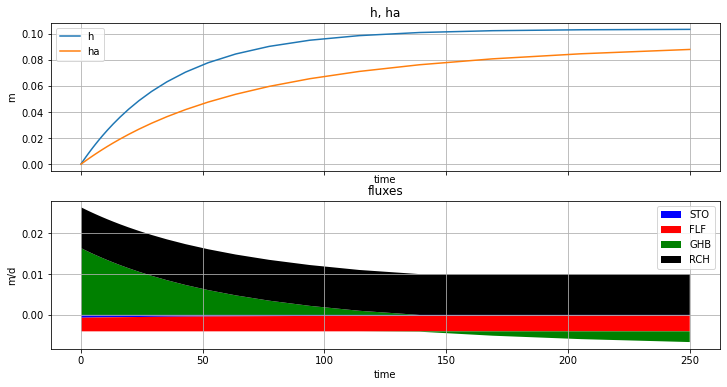

In [319]:
ip, it = 0, 0
mu, b, k, D, c, w = propdata.iloc[ip][['sy', 'b', 'k', 'D', 'c', 'w']]
N, phi, hlr       = perdata.iloc[ it][['N', 'phi', 'hlr']]
N = 0.01
h0 = 0 
T = mu * c

lam = np.sqrt(k * D * c)
blam = b / lam
Lam = 1 / (blam * np.cosh(blam) / np.sinh(blam) + (b * w) / (D * c))
G = blam * np.cosh(blam) / np.sinh(blam)
cb = w / D * b

times = np.logspace(-1, np.log10(250), 41)
h    = np.zeros_like(times)
ha   = np.zeros_like(times)
qSTO = np.zeros_like(times)
qFLF = np.zeros_like(times)
qGHB = np.zeros_like(times)
qRCH = np.zeros_like(times)

e = np.exp(-times / T)
f = (1 - np.exp(-times/T)) * (T / times)
h  = phi + (h0 - phi) * e + (N * c * (1 - Lam) + (hlr - phi) * Lam) * (1 - e)
ha = phi + (h0 - phi) * f + (N * c * (1 - Lam) + (hlr - phi) * Lam) * (1 - f)

# Flow terms with alternative formulations
qRCH = N
qSTO = ((h0 - phi) / c - N * (1 - Lam) - (hlr - phi) / c * Lam) * f
qSTO = -mu * (h - h0) / times
qFLF = - (ha - phi) / c
qFLF = - (h0 - phi)/ c * f - (N * (1 - Lam) + (hlr - phi) /c * Lam ) * (1 - f)
qGHB = -qSTO - N - qFLF
qGHB = ((hlr - phi) / c - N )* Lam
qGHB = - N * c / cb + (N * c  / cb - (ha - phi) / cb
                      ) *blam * np.cosh(blam) / np.sinh(blam) + (hlr - phi) / cb

# The strange thing is that qGHB is constant !! (I don't understand why!)

ax = ga.newfig2(['h, ha', 'fluxes'], 'time', ['m', 'm/d'])
ax[0].plot(times, h, label='h')
ax[0].plot(times, ha, label='ha')
ax[0].legend()

V = np.zeros((4, len(times)))
for i, q in enumerate([qSTO, qFLF, qGHB, qRCH]):
    V[i] = q

clrs = ['b', 'r', 'g', 'k', 'm', 'c']
ax[1].stackplot(times, V * (V > 0), labels=['STO', 'FLF', 'GHB', 'RCH'], colors=clrs)
ax[1].stackplot(times, V * (V < 0), colors=clrs)
ax[1].legend()